# Applied Machine Learning: Credit Card Approval Prediction

*By Daniel Deutsch and José Lucas Barretto*

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

c:\Users\Dell\Desktop\Code\FTD\Applied ML\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 7),
    'axes.prop_cycle': plt.cycler(color=['#4C72B0', '#C44E52', '#55A868', '#8172B2', '#CCB974', '#64B5CD']),
    'axes.facecolor': '#EAEAF2'
})

# Random state
random_state = 42

## Data Processing

At this staage the goal is to read both datasets and adapt its content for our classification models.

### Processing raw data

#### Credit records

In [3]:
# Reads the dataset
df_credit_record = pd.read_csv("./datasets/credit_record.csv")

# Renames columns
df_credit_record.rename(columns=str.lower, inplace=True)

# Numericalize status
df_credit_record.replace({'status': {'X': 0, 'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}}, inplace=True)

# Calculates the metric
df_credit_record = df_credit_record.groupby('id')['status'].agg(['mean', 'max', 'count']).reset_index()

# Removes clients without a considerate amount of records
df_credit_record = df_credit_record[df_credit_record['count'] > 12]

# Sets the label
df_credit_record['is_good_safe'] = 1*(df_credit_record['mean'] < df_credit_record['mean'].quantile(0.15))
df_credit_record['is_good_risky'] = 1*(df_credit_record['mean'] < df_credit_record['mean'].quantile(0.25))
df_credit_record['is_good_riskier'] = 1*(df_credit_record['mean'] < df_credit_record['mean'].quantile(0.35))

#### Application Records

In [4]:
# Reads the dataset
df_application_record = pd.read_csv("./datasets/application_record.csv")

# Renames columns
df_application_record.rename(columns=str.lower, inplace=True)

# Numericalyze and rename education level
df_application_record.replace({
    'name_education_type': {
        'Higher education': 4,
        'Academic degree': 4,
        'Incomplete higher': 3,
        'Secondary / secondary special': 2,
        'Lower secondary': 1, 
    }
}, inplace=True)
df_application_record.rename(columns={'name_education_type': 'education_level'}, inplace=True)

# Transform days employed into is_unemployed
df_application_record['is_unemployed'] = 1*(df_application_record['days_employed'] > 0)

# Drop uninteresting columns - birthday, days employed
df_application_record.drop(columns=['days_employed', 'days_birth'], inplace=True)

#### Merging data

In [5]:
df = pd.merge(df_credit_record, df_application_record, how='inner', on='id')

### Train-test split

In [6]:
# Define categorical, numerical, and other interesting vars
categorical = [
    'code_gender', 
    'flag_own_car', 
    'flag_own_realty', 
    'name_income_type',
    'name_family_status', 
    'name_housing_type', 
    'flag_mobil', 
    'flag_work_phone',
    'flag_phone', 
    'flag_email',
    'occupation_type'
]

numerical = [
    'cnt_children',
    'amt_income_total',
    'cnt_fam_members'
]

other = [
    'is_unemployed',
    'education_level'
]

# Define X and y datasets
X = df[categorical + numerical + other]
y = df[['is_good_safe', 'is_good_risky', 'is_good_riskier']]

# Split between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

### Processing features

In [7]:
# Initialize encoder for categorical vars
enc = OneHotEncoder(drop='first', sparse=False)

# Fit transform encoder to train data
X_train_categorical = pd.DataFrame(enc.fit_transform(X_train[categorical]), index=X_train.index, columns=enc.get_feature_names_out())

# Transform encoder to test data
X_test_categorical = pd.DataFrame(enc.transform(X_test[categorical]), index=X_test.index, columns=enc.get_feature_names_out())

In [8]:
# Initialize scaler for numerical vars
scaler = StandardScaler()

# Fit transform scaler to train data
X_train_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical]), index=X_train.index, columns=numerical)

# Transform scaler to test data
X_test_numerical = pd.DataFrame(scaler.transform(X_test[numerical]), index=X_test.index, columns=numerical)

In [9]:
# Concatenate numerical and categorical vars
X_train_normal = pd.concat((X_train_numerical, X_train_categorical, X_train[other]), axis=1)
X_test_normal = pd.concat((X_test_numerical, X_test_categorical, X_test[other]), axis=1)

# Data Visualization

In [10]:
print(f"The worst client considered as good in the safe category is labeled as {df_credit_record[df_credit_record['is_good_safe'] == 1]['max'].max()}")
print(f"The worst client considered as good in the risky category is labeled as {df_credit_record[df_credit_record['is_good_risky'] == 1]['max'].max()}")
print(f"The worst client considered as good in the riskier category is labeled as {df_credit_record[df_credit_record['is_good_riskier'] == 1]['max'].max()}")

The worst client considered as good in the safe category is labeled as 2
The worst client considered as good in the risky category is labeled as 3
The worst client considered as good in the riskier category is labeled as 6


# Modeling, Feature Selection, Explainability

## Safe Risk Profile

### Logistic Regression (Benchmark)

In [11]:
# Builds and trains the model
model = LogisticRegressionCV(cv=3, penalty='l2', scoring='roc_auc', class_weight='balanced', solver='liblinear')
model_fit = model.fit(X_train_normal, y_train['is_good_safe'])

# Prints the classification report
print(classification_report(y_test['is_good_safe'], model_fit.predict(X_test_normal), zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test['is_good_safe'], model_fit.predict(X_test_normal))}")

              precision    recall  f1-score   support

           0       0.87      0.52      0.65      6076
           1       0.14      0.48      0.21       950

    accuracy                           0.52      7026
   macro avg       0.50      0.50      0.43      7026
weighted avg       0.77      0.52      0.59      7026

ROC AUC: 0.5022939260593882


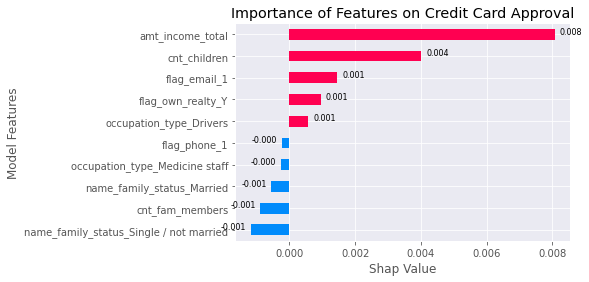

In [12]:
explainer = shap.Explainer(model, X_train_normal)
shap_values = explainer(X_test_normal)

coefs = pd.DataFrame(shap_values.values.mean(axis=0), index=X_train_normal.columns)
coefs.columns = ['shap']
coefs['positive'] = coefs['shap'] > 0
coefs.sort_values('shap', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['shap'].plot(kind='barh', color=coefs.positive.map({True: '#FF0051', False: '#008BFB'}))

ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 6), size=8, textcoords='offset points')
    else:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 6), size=8, textcoords='offset points')

plt.xlabel("Shap Value")
plt.ylabel("Model Features")
plt.title("Importance of Features on Credit Card Approval")
plt.show()

### Random Forest

In [13]:
# Defines the grid parameters
param_grid = {
    'n_estimators': [500],
    'max_depth': [1000],
    'max_features': [5, 15, X_train_normal.shape[1]]
}

# Builds and trains the model
model = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    # verbose=3
)
model_fit = model.fit(X_train_normal, y_train['is_good_safe'])

In [14]:
# Prints the classification report
print(classification_report(y_test['is_good_safe'], model_fit.predict(X_test_normal), zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test['is_good_safe'], model_fit.predict(X_test_normal))}")

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6076
           1       0.49      0.28      0.36       950

    accuracy                           0.86      7026
   macro avg       0.69      0.62      0.64      7026
weighted avg       0.84      0.86      0.85      7026

ROC AUC: 0.617764283981844


In [17]:
explainer = shap.TreeExplainer(model_fit.best_estimator_, X_train_normal)
shap_values = explainer(shap.sample(X_test_normal), check_additivity=False)

 99%|===================| 198/200 [01:03<00:00]        

In [21]:
shap.bar_plot(shap_values)

TypeError: bad operand type for abs(): 'Explanation'

In [ ]:
# explainer = shap.TreeExplainer(model_fit.best_estimator_, X_train_normal)
# shap_values = explainer(X_test_normal)

coefs = pd.DataFrame(shap_values.values.mean(axis=0), index=X_train_normal.columns)
coefs.columns = ['shap']
coefs['positive'] = coefs['shap'] > 0
coefs.sort_values('shap', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['shap'].plot(kind='barh', color=coefs.positive.map({True: '#FF0051', False: '#008BFB'}))

ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 6), size=8, textcoords='offset points')
    else:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 6), size=8, textcoords='offset points')

plt.xlabel("Shap Value")
plt.ylabel("Model Features")
plt.title("Importance of Features on Credit Card Approval")
plt.show()

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

## Risky Risk Portfolio

### Logistic Regression (Benchmark)

### Random Forest

#### Training and Evaluating the Model

In [155]:
# Defines the grid parameters
param_grid = {
    'n_estimators': [250, 300, 500],
    'max_depth': [500, 1000, 2000],
    'max_features': [5, 10, 20, X_train_normal.shape[1]]
}

# Builds and trains the model
model = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    # verbose=3
)
model_fit.fit(X_train_normal, y_train['is_good_safe'])

#
clf_tuned.best_estimator_

ValueError: y should be a 1d array, got an array of shape (16393, 3) instead.

In [12]:
pred = clf_tuned.best_estimator_.predict(X_test_normal)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.41      0.13      0.20       406
           1       0.97      0.99      0.98     10532

    accuracy                           0.96     10938
   macro avg       0.69      0.56      0.59     10938
weighted avg       0.95      0.96      0.95     10938



#### Feature Importance

##### Permutation Importance

In [13]:
feature_names = X_train_normal.columns

result = permutation_importance(
    clf_tuned.best_estimator_, X_test_normal, y_test, n_repeats=10, n_jobs=-1, random_state=random_state
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

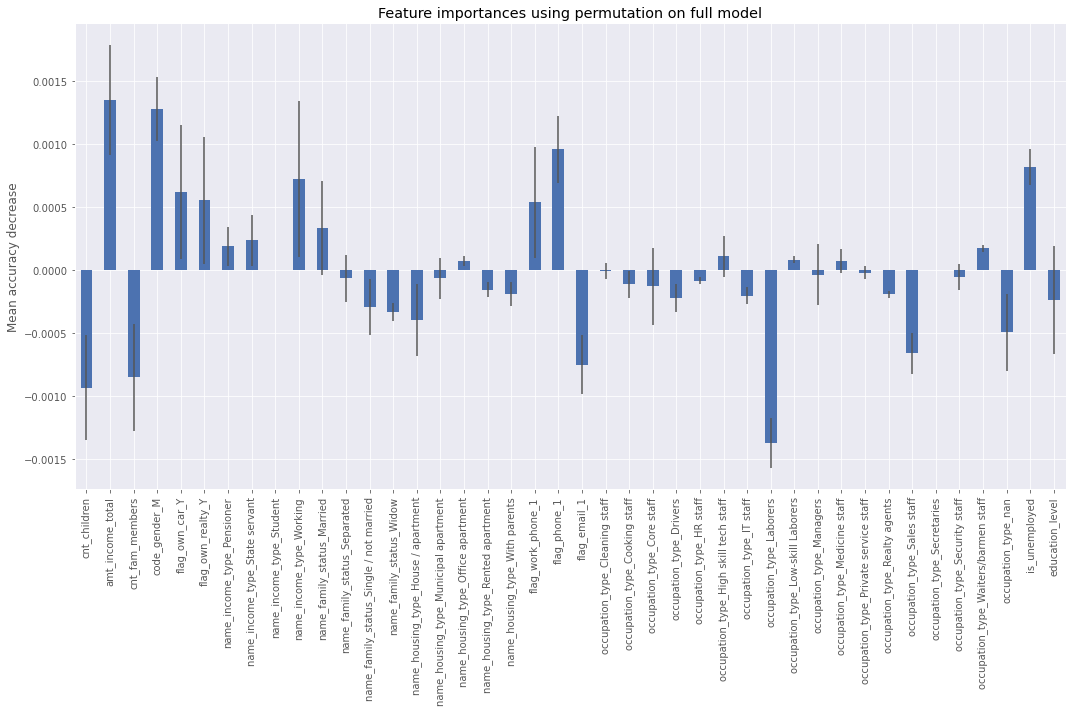

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

##### Synergy and Redundance